# All imports necessary

In [1]:
import sys

In [2]:
sys.path.append('..')

In [3]:
from source.code.models.songfrequencybasedrecommender import SongFrequencyBasedRecommender

In [4]:
import os
import pandas as pd
import numpy as np

In [5]:
import seaborn as sns

In [6]:
import matplotlib.pyplot as plt

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
from sklearn.model_selection import cross_val_score

In [9]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [10]:
from scipy.sparse import csr_matrix

In [11]:
from sklearn.decomposition import TruncatedSVD

In [105]:
from sklearn.preprocessing import MinMaxScaler

In [211]:
from sklearn.preprocessing import MaxAbsScaler

In [93]:
import tqdm

In [94]:
import math

# Read the data

## Song extra info

In [12]:
data_directory = '../data/datasets/'

In [13]:
song_extra_info = pd.read_csv(os.path.join(data_directory, 'song_extra_info.csv'))

In [14]:
song_extra_info.head()

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


In [15]:
song_extra_info.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2295971 entries, 0 to 2295970
Data columns (total 3 columns):
song_id    2295971 non-null object
name       2295969 non-null object
isrc       2159423 non-null object
dtypes: object(3)
memory usage: 52.6+ MB


## Train

In [16]:
train = pd.read_csv(os.path.join(data_directory, 'train.csv'), engine='python')

In [17]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [18]:
train.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 6 columns):
msno                  7377418 non-null object
song_id               7377418 non-null object
source_system_tab     7352569 non-null object
source_screen_name    6962614 non-null object
source_type           7355879 non-null object
target                7377418 non-null int64
dtypes: int64(1), object(5)
memory usage: 337.7+ MB


In [19]:
train['data_from'] = 'train'

In [20]:
train.msno.nunique()

30755

In [21]:
train.song_id.nunique()

359966

In [22]:
train.source_system_tab.nunique()

8

In [23]:
train.source_system_tab.value_counts()

my library      3684730
discover        2179252
search           623286
radio            476701
listen with      212266
explore          167949
notification       6185
settings           2200
Name: source_system_tab, dtype: int64

In [24]:
train.source_screen_name.nunique()

20

In [25]:
train.source_screen_name.value_counts()

Local playlist more     3228202
Online playlist more    1294689
Radio                    474467
Album more               420156
Search                   298487
Artist more              252429
Discover Feature         244246
Discover Chart           213658
Others profile more      201795
Discover Genre            82202
My library                75980
Explore                   72342
Unknown                   54170
Discover New              15955
Search Trends             13632
Search Home               13482
My library_Search          6451
Self profile more           212
Concert                      47
Payment                      12
Name: source_screen_name, dtype: int64

In [26]:
train.source_type.nunique()

12

In [27]:
train.source_type.value_counts()

local-library             2261399
online-playlist           1967924
local-playlist            1079503
radio                      483109
album                      477344
top-hits-for-artist        423614
song                       244722
song-based-playlist        210527
listen-with                192842
topic-article-playlist      11194
artist                       3038
my-daily-playlist             663
Name: source_type, dtype: int64

In [28]:
train.fillna('unknown', inplace=True)

In [29]:
train.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 7 columns):
msno                  7377418 non-null object
song_id               7377418 non-null object
source_system_tab     7377418 non-null object
source_screen_name    7377418 non-null object
source_type           7377418 non-null object
target                7377418 non-null int64
data_from             7377418 non-null object
dtypes: int64(1), object(6)
memory usage: 394.0+ MB


## Test

In [30]:
test = pd.read_csv(os.path.join(data_directory, 'test.csv'), engine='python', index_col=0)

In [31]:
test.head()

,msno,song_id,source_system_tab,source_screen_name,source_type
id,,,,,
0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist
3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio
4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio


In [32]:
test.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2556790 entries, 0 to 2556789
Data columns (total 5 columns):
msno                  2556790 non-null object
song_id               2556790 non-null object
source_system_tab     2548348 non-null object
source_screen_name    2393907 non-null object
source_type           2549493 non-null object
dtypes: object(5)
memory usage: 117.0+ MB


In [33]:
test['target'] = None

In [34]:
test['data_from'] = 'test'

In [35]:
test.msno.nunique()

25131

In [36]:
test.song_id.nunique()

224753

In [37]:
test.source_system_tab.nunique()

8

In [38]:
test.source_system_tab.value_counts()

my library      1019492
discover         871068
search           277615
radio            212765
listen with       98628
explore           66023
notification       2124
settings            633
Name: source_system_tab, dtype: int64

In [39]:
test.source_screen_name.nunique()

22

In [40]:
test.source_screen_name.value_counts()

Local playlist more     845115
Online playlist more    529807
Radio                   211201
Album more              176129
Search                  121982
Artist more             110999
Discover Feature         93401
Others profile more      90457
Discover Chart           78999
Discover Genre           41617
Explore                  27872
My library               25559
Unknown                  23620
Discover New              5277
Search Trends             4883
Search Home               4705
My library_Search         2114
Self profile more          131
Concert                     13
People local                13
Payment                     12
People global                1
Name: source_screen_name, dtype: int64

In [41]:
test.source_type.nunique()

12

In [42]:
test.source_type.value_counts()

online-playlist           774532
local-library             582346
local-playlist            294537
radio                     215164
album                     195190
top-hits-for-artist       179360
song                      129153
song-based-playlist        87179
listen-with                84499
topic-article-playlist      5082
my-daily-playlist           2023
artist                       428
Name: source_type, dtype: int64

In [43]:
test.fillna('unknown', inplace=True)

In [44]:
test.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2556790 entries, 0 to 2556789
Data columns (total 7 columns):
msno                  2556790 non-null object
song_id               2556790 non-null object
source_system_tab     2556790 non-null object
source_screen_name    2556790 non-null object
source_type           2556790 non-null object
target                2556790 non-null object
data_from             2556790 non-null object
dtypes: object(7)
memory usage: 156.1+ MB


## Songs

In [ ]:
songs = pd.read_csv(os.path.join(data_directory, 'songs.csv'))

In [ ]:
songs.head()

In [ ]:
songs.info(verbose=True, null_counts=True)

In [ ]:
songs.lyricist.fillna('unknown', inplace=True)

In [ ]:
songs.composer.fillna('unknown', inplace=True)

In [ ]:
songs.language.fillna(-1, inplace=True)

In [ ]:
songs.language = songs.language.astype(np.int64)

In [ ]:
songs.head()

In [ ]:
songs.info(verbose=True, null_counts=True)

In [ ]:
songs.song_length.nunique()

In [ ]:
songs.genre_ids.nunique()

In [ ]:
songs.artist_name.nunique()

In [ ]:
songs.composer.nunique()

In [ ]:
songs.lyricist.nunique()

In [ ]:
songs.language.nunique()

## Members

In [ ]:
members = pd.read_csv(os.path.join(data_directory, 'members.csv'))

In [ ]:
members.head()

In [ ]:
members.info(verbose=True, null_counts=True)

In [ ]:
members.fillna('unknown', inplace=True)

In [ ]:
members.info(verbose=True, null_counts=True)

In [ ]:
members.head()

## Sample submission

In [ ]:
sample_submission = pd.read_csv(os.path.join(data_directory, 'sample_submission.csv'))

In [ ]:
sample_submission.head(10)

In [ ]:
sample_submission.info(verbose=True, null_counts=True)

# Solutions

In [46]:
X, y = train[train.columns[:-2]], train[train.columns[-2]]

In [47]:
X_for_submission = test[test.columns[:-2]]

In [48]:
X.head()

,msno,song_id,source_system_tab,source_screen_name,source_type
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist


In [49]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

In [50]:
X_for_submission.head()

,msno,song_id,source_system_tab,source_screen_name,source_type
id,,,,,
0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,unknown,song-based-playlist
3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio
4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio


In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.33,
    random_state=42,
    stratify=y
)

## Naive frequency approach

In [ ]:
naive_frequency_recommender = SongFrequencyBasedRecommender()

In [ ]:
print('\t', cross_val_score(naive_frequency_recommender, X_train, y_train, cv=5))

In [ ]:
naive_frequency_recommender.fit(X_train, y_train)

In [ ]:
y_pred = naive_frequency_recommender.predict(X_test)

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## SVD

In [173]:
unique_users = list(set(X_train.msno))

In [174]:
unique_songs = list(set(X_train.song_id))

In [175]:
user2index = dict(zip(unique_users, range(len(unique_users))))

In [176]:
song2index = dict(zip(unique_songs, range(len(unique_songs))))

In [177]:
index2user = dict(zip(range(len(unique_users)), unique_users))

In [178]:
index2song = dict(zip(range(len(unique_songs)), unique_songs))

In [179]:
user_indexes = X_train.msno.map(user2index).values

In [180]:
song_indexes = X_train.song_id.map(song2index).values

In [181]:
flags = y_train.values

In [182]:
sparse_matrix = csr_matrix(
    arg1=(flags, (user_indexes, song_indexes)),
    shape=(len(unique_users), len(unique_songs))
)

In [183]:
svd = TruncatedSVD(n_components=10, n_iter=20, random_state=42)

In [184]:
svd.fit(sparse_matrix)

TruncatedSVD(algorithm='randomized', n_components=10, n_iter=20,
       random_state=42, tol=0.0)

In [185]:
users_representations = svd.transform(sparse_matrix)

In [186]:
type(users_representations)

numpy.ndarray

In [187]:
users_representations.shape

(30373, 10)

In [188]:
users_representations.max()

14.083811544489295

In [189]:
song_representations = svd.components_

In [190]:
type(song_representations)

numpy.ndarray

In [191]:
song_representations.shape

(10, 298347)

In [192]:
song_representations.max()

0.18908269230693064

In [193]:
y_pred = []
for user, song in zip(X_test.msno.values, X_test.song_id.values):
    if user in user2index and song in song2index:
        y_pred.append(np.dot(users_representations[user2index[user], :], song_representations[:, song2index[song]]))
    else:
        y_pred.append(0.5)

In [203]:
min(y_pred)

-0.9315559302597352

In [204]:
max(y_pred)

1.5846305771130473

In [222]:
y_pred_scaled = MaxAbsScaler().fit_transform(np.reshape(y_pred, (1, -1)))

In [228]:
y_pred_scaled = MinMaxScaler().fit_transform(np.reshape(y_pred, (1, -1)))

In [229]:
y_pred_scaled.shape

(1, 2434548)

In [230]:
y_pred_scaled[0].shape

(2434548,)

In [233]:
min(y_pred_scaled)

array([0., 0., 0., ..., 0., 0., 0.])

In [234]:
max(y_pred_scaled)

array([0., 0., 0., ..., 0., 0., 0.])

In [225]:
fpr, tpr, _ = roc_curve(y_test, y_pred_scaled[0])

In [172]:
max(y_pred[0])

0.0

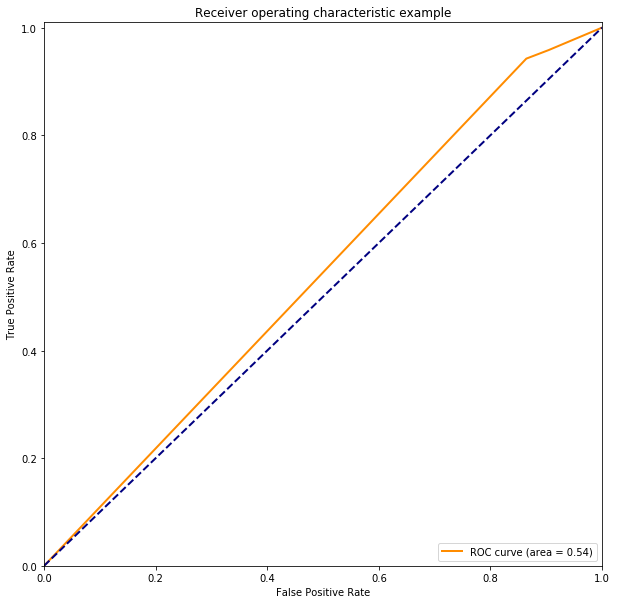

In [235]:
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()